In [1]:
import numpy
from matplotlib import pyplot
from matplotlib import colors
% matplotlib inline

In [2]:
from collections.abc import Mapping

In [3]:
import os, sys
sys.path.append(os.path.split(os.getcwd())[0])

In [4]:
import utils.poly as poly
import utils.quadrature as quad

$$
\frac{\partial u}{\partial t} + \frac{\partial u}{\partial x} = 0
$$

$$
u_{init} = e^{-40(x-0.5)^2}
$$

$$
u_{exact} = e^{\left[-40(x-0.5-t)^2\right]}
$$

In [5]:
def u_init(x):
    """initial condition of u"""
    temp = x - 0.5
    return numpy.exp(-40 * temp * temp)

In [6]:
def flux(u):
    """flux in PDE"""
    return u

In [7]:
def u_exact(x, t):
    """exact solution of u"""
    temp = x - 0.5 - t
    return numpy.exp(-40 * temp * temp)

In [8]:
def equalDistrib(N):
    """"""
    return numpy.linspace(-1., 1., N, endpoint=False) + 1. / N

In [9]:
def LegendreLobatto(N):
    """"""
    return quad.GaussLobattoJacobi(N).nodes

In [10]:
def LegendreGauss(N):
    """"""
    return quad.GaussJacobi(N).nodes

In [11]:
def ChebyshevLobatto(N):
    """"""
    return - numpy.cos(numpy.arange(N, dtype=numpy.float64) * numpy.pi / (N-1))

In [12]:
class Config(Mapping):
    """a dict-like data structure for configurations"""
    
    def __init__(self, config=None):
        """initialization
        
        Args:
            config: string or file containing configurations
        """
        # TODO: check the type of config
        # TODO: implement reading configurations from config
        
        self._storage = dict(        
            xLB = 0.,
            xRB = 1.,
            Ne = 10,
            K = 4,
            g_type = "g1",
            node_type = "LegendreGauss",
            BCL = "periodic",
            BCR = "periodic")
    def __getitem__(self, key):
        """"""
        return self._storage[key]
    
    def __iter__(self):
        """"""
        return iter(self._storage)
    
    def __len__(self):
        """"""
        return len(self._storage)

In [13]:
class Element(numpy.ndarray):
    """"""
    
    def __new__(cls, xL, xR, x):
        """initialization
        
        Args:
            xL: float, the coordinate of left boundary
            xR: float, the coordinate of right boundary
            x: array-like float, global coordinates of points on this element
        """
        # TODO: check the type of input arguments
        
        return x.view(cls)
    
    def __init__(self, xL, xR, x):
        """initialization
        
        Args:
            xL: float, the coordinate of left boundary
            xR: float, the coordinate of right boundary
            x: array-like float, global coordinates of points on this element
        """
        # TODO: check the type of input arguments
        
        self.xL = numpy.float64(xL)
        self.xR = numpy.float64(xR)
        self.h = self.xR - self.xL
        self.xc = 0.5 * (self.xL + self.xR)
        self.J = 0.5 * self.h
        self.Jinv = 2. / self.h
        
        self.basis = poly.LagrangeBasis(x)
        self.D = self.basis.derivative(x)
        
        self.K = x.size

    def coord_l2g(self, xi):
        """coordinate transform from local (xi) to global (x)"""
        return self.xc + self.J * xi

    def coord_g2l(self, x):
        """coordinate transform from global (x) to local (xi)"""
        return self.Jinv * (x - self.xc)

In [14]:
class ElementSet(object):
    """"""
    
    distrib_pnts = {
        "equal": equalDistrib,
        "LegendreLobatto": LegendreLobatto,
        "LegendreGauss": LegendreGauss,
        "ChebyshevLobatto": ChebyshevLobatto}
    
    def __init__(self, config):
        """initialization
        
        Args:
            config: an instance of class Config
        """
        
        self.K = config['K']
        self.xLB = config["xLB"]
        self.xRB = config["xRB"]
        self.Ne = config["Ne"]
        self.distrib = config["node_type"]
        
        self._init_interface()
        self._init_element()
        self._build_transform()
        self._get_all_x()
    
    def _init_element(self):
        """initialize each element"""
        
        self.elements = {
            i: Element(self.interface_x[i], self.interface_x[i+1],
                       self.distrib_pnts[self.distrib](self.K))
                         for i in range(self.Ne)}

    def _build_transform(self):
        """"""
        
        self.Np = 0
        self.jk2g = {}
        self.g2jk = {}
        for j in range(self.Ne):
            self.jk2g.update({(j, k): self.Np+k for k in range(self.elements[j].K)})
            self.g2jk.update({self.Np+k: (j, k) for k in range(self.elements[j].K)})
            self.Np += self.elements[j].K
    
    def _init_interface(self):
        """initialize interface information"""
        
        self.Ni = self.Ne + 1
        self.interface_x = numpy.linspace(self.xLB, self.xRB, self.Ni)
        self.interface_i2e = {i: (i-1, i) for i in range(self.Ni)}
        self.interface_e2i = {v: k for k, v in self.interface_i2e.items()}
    
    def _get_all_x(self):
        """"""
        # TODO: not perfect
        self.x = numpy.zeros(self.Np, dtype=numpy.float64)
        for i, (j, k) in self.g2jk.items():
            self.x[i] = self.elements[j].coord_l2g(self.elements[j][k])

In [15]:
class LocalSolutionPnts(numpy.ndarray):
    """data structure for solution valuess built on a given element"""
    
    def __new__(cls, element, x):
        """initialization
        
        Args:
            x: array-like float, global coordinates of points on this element
        """
        # TODO: check the type of input arguments
        
        return x.view(cls)
    
    def __init__(self, element, x):
        """initialization
        
        Args:
            element: an instance of class Element
            ic: initialization function, i.e., initial conditions
        """
        # TODO: check the type of input arguments
        
        self.element = element
    
    def __call__(self, xi):
        """return interpolated u at location x (or xi)
        
        Args:
            xi: float, local coordinates
        """
        return numpy.dot(self.element.basis(xi), self.__array__())

In [16]:
class SolutionPntSet(numpy.ndarray):
    """"""
    
    def __new__(cls, grid, ic):
        """"""
        obj = ic.copy().view(cls)
        obj.grid = grid
        obj.local_soln = {}
        for i in range(obj.grid.Ne):
            
            bg = obj.grid.jk2g[(i, 0)]
            ed = bg + obj.grid.K
            
            obj.local_soln[i] = LocalSolutionPnts(
                obj.grid.elements[i], obj[bg:ed])
        
        obj.update_ghost()
        
        return obj
    
    def update_ghost(self):
        """
        Currently only support periodic BC
        """
        self.local_soln[-1] = self.local_soln[self.grid.Ne-1]
        self.local_soln[self.grid.Ne] = self.local_soln[0]

In [76]:
class FR1D(object):
    """"""
    
    def __init__(self, flux, grid, config):
        """"""
        
        self.grid = grid
        self.flux = flux
        #self.dgBL = poly.Radau(self.grid.K, end=1.).derive()
        #self.dgRL = poly.Radau(self.grid.K, end=-1.).derive()
        self.dgBL = poly.Lagrange(ChebyshevLobatto(self.grid.K+1),
                     numpy.array([1.]+self.grid.K*[0.])).derivative
        self.dgRL = poly.Lagrange(ChebyshevLobatto(self.grid.K+1),
                     numpy.array(self.grid.K*[0.]+[1.])).derivative
    
    def __call__(self, u):
        """
        
        Return RHS in time-marching schemes
        """
        pass
        
        # step 1 & 2: calculate fupw at each interface
        fupw = self._cal_fupw(u)
        
        # step 3, 4: calculate df/dxi at solution points
        dF = self._get_dfjk(u, fupw)
        
        return dF
    
    def _cal_fupw(self, u):
        """"""
        fupw = numpy.zeros_like(self.grid.interface_x)
        for i in range(self.grid.Ni):
            (idL, idR) = self.grid.interface_i2e[i]
            uL = u.local_soln[idL](1.0)
            uR = u.local_soln[idR](-1.0)
            f_uL = self.flux(uL)
            f_uR = self.flux(uR)
            
            # for different kind problem, both cases have different values of a
            if uL == uR:
                a = 1.
            else:
                a = (f_uR - f_uL) / (uR - uL)
            
            fupw[i] = 0.5 * (f_uL + f_uR) - 0.5 * numpy.abs(a) * (uR - uL)
        
        return fupw
    
    def _get_dfjk(self, u, fupw):
        """"""
        df = SolutionPntSet(self.grid, self.flux(u))
        for j, e in self.grid.elements.items():
            fLupw = fupw[self.grid.interface_e2i[(j-1, j)]]
            fRupw = fupw[self.grid.interface_e2i[(j, j+1)]]
            fjL = df.local_soln[j](-1.)
            fjR = df.local_soln[j](1.)
            correctL = (fLupw - fjL) * self.dgBL(e)
            correctR = (fRupw - fjR) * self.dgRL(e)
            df.local_soln[j][:] = \
                numpy.dot(e.D, df.local_soln[j]) + correctL + correctR
            df.local_soln[j][:] *= e.Jinv
            
        return df

In [86]:
xBC_L = 0.
xBC_R = 1.
L = 1.

N = 10
Npe = 4
Np = N * Npe

CFL = 0.750469
dx = L / Np
Nt = 432
dt = 10./Nt

In [87]:
config = Config()
E = ElementSet(config)
u = SolutionPntSet(E, u_init(E.x))
fr = FR1D(flux, E, config)

In [83]:
def RK4(u, dt, rhs):
    """"""
    k1 = rhs(u)
    k2 = rhs(SolutionPntSet(E, u-0.5*dt*k1))
    k3 = rhs(SolutionPntSet(E, u-0.5*dt*k2))
    k4 = rhs(SolutionPntSet(E, u-dt*k3))
    u -= dt * (k1 + 2. * k2 + 2. * k3 + k4) / 6.
    return u

In [88]:
for i in range(5*Nt):
    RK4(u, dt, fr)

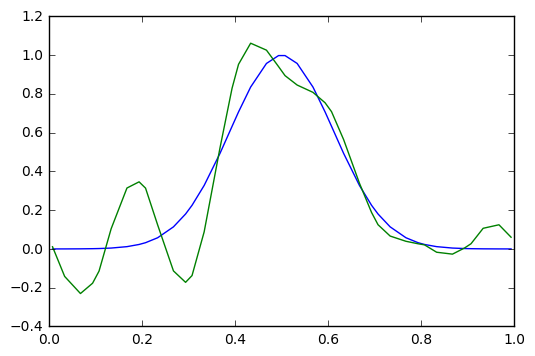

In [89]:
pyplot.plot(E.x, u_init(E.x))
pyplot.plot(E.x, u)